# Analysing the experimental data of  [Brydges et al, Science 2019](https://doi.org/10.1126/science.aau4963)

In this example, we illustrate the functionalities of the RandomMeas.jl package using actual experimental data obtained in  [Brydges et al., 2019](https://doi.org/10.1126/science.aau4963). It aims to estimate the purity and (higher-order) Renyi entropies of quantum states generated in an ion-trap quantum simulator.

## Experiment Description

The original experiment [Brydges et al., 2019] focused on measuring the purity (the second Renyi enropy) in an ion-trap quantum simulator. The main goals were:

- **Purity Measurement:**  
  To verify that the quantum device produces a nearly unitary dynamics, we measure the purity $Tr[\rho^2]$ of the (full-system) quantum state.

- **Entanglement Quantification:**  
  Subsystem purities are used to compute the second Rényi entropy, defined as  
  $$
  S_2(\rho_A) = -\log_2(p_2)
  $$
  where $ p_2 = Tr[\rho_A^2] $ is the purity of a subsystem. This metric provides insights into the entanglement structure of many-body quantum systems.

- **Experimental Setup:**  
  - The system consists of a chain of trapped ions (here $ N = 10 $ ), with each ion encoding a qubit.
  - Initial state: The qubits are initialized in a Néel state,
    $\ket{\psi} = \ket{01}^{\otimes (N/2)}$.
  - Quench dynamics: The system is evolved under an XY Hamiltonian,  
    $$
    H_{XY} = \sum_{i<j} J_{ij} \left( \sigma_i^+ \sigma_j^- + \text{h.c.} \right)
    $$
    with couplings $ J_{ij} \sim \frac{J}{|i - j|^\alpha} $ (with $ 0 < \alpha < 3 $) up to various times t.
  - Randomized measurements are performed by applying local single-qubit rotations sampled from the circular unitary ensemble before measurement. These rotations, combined with standard $Z$-basis measurements, yield data that is used to estimate purity and entanglement.

The experiment acquired data for multiple measurement settings ( $ N_U = 500 $ settings, each with $ N_M = 150 $ repetitions per settings).

## Notebook Overview

This notebook demonstrates several key functionalities of the RandomMeas.jl package:

- **Loading Experimental Data:**  
  The notebook shows how to load measurement data from NPZ files. The data consists of measurement results (a 3D array with dimensions $(NU, NM, N)$) and  includes local unitary measurement settings.

- **Direct Purity Estimation:**  
  Using the estimator presented in [Brydges et al., 2019], the notebook estimates the purity of the quantum state for various subsystem sizes (up to 10 sites).

- **Batch Classical Shadows:**  
  The notebook also demonstrates how to construct (batch) dense shadows and estimates higher order trace moments using U-statistics estimators. This approach allows us to extract higher-order Rényi entropies, albeit for smaller subsystems (up to $N_A = 6$).

- **Comparison to numerical simulations:**  
  Finally, the notebook includes an example of loading numerically simulated (theory) states generated using a decoherence model. These states are converted to MPO representations, and their Rényi entropies are computed to compare with the experimental data.

## Reference

Brydges, T., Elben, A., Jurcevic, P., Vermersch, B., Maier, C., Lanyon, B. P., Zoller, P., Blatt, R., & Roos, C. F. (2019). *Probing Rényi entanglement entropy via randomized measurements*. **Science, 364**(6437), 260–263.  [DOI: 10.1126/science.aau4963](https://doi.org/10.1126/science.aau4963)

In [11]:
using RandomMeas

In [12]:
## parameters 
N = 10 # System size
times = [0,1,2,3,4,5] # quench times in ms
ntimes = length(times)  # number of time points
ξ = siteinds("Qubit", N); # site indices of the shadows

## Loading Experimental Data

We now load the experimental randomized measurement data obtained in [Brydges et al., 2019](https://doi.org/10.1126/science.aau4963). In this experiment, the goal was to probe the purity and entanglement of a quantum state generated in an ion-trap quantum simulator.

For each quench time $ t $ (0, 1, 2, 3, 4, 5 ms), we generate one measurement group. Each measurement group contains $ N_U = 500 $ measurement data objects, where each object consists of:
  
- **Experimental Data:**  
  The measurement outcomes obtained from $ N_M = 150 $ projective measurements for a given measurement setting.
  
- **Measurement Setting:**  
  The corresponding local random unitaries that specify the measurement setting for that data.

In [13]:
data = Vector{MeasurementGroup}(undef, ntimes)

for s in 1:ntimes
    data[s] = import_MeasurementGroup("BrydgesScience2019data/measurement_data_10_T_" * string(times[s]) * ".npz",site_indices=ξ)
end 

We are constructing a MeasurementGroup object with measurement settings of type LocalUnitaryMeasurementSetting.
We are constructing a MeasurementGroup object with measurement settings of type LocalUnitaryMeasurementSetting.
We are constructing a MeasurementGroup object with measurement settings of type LocalUnitaryMeasurementSetting.
We are constructing a MeasurementGroup object with measurement settings of type LocalUnitaryMeasurementSetting.
We are constructing a MeasurementGroup object with measurement settings of type LocalUnitaryMeasurementSetting.
We are constructing a MeasurementGroup object with measurement settings of type LocalUnitaryMeasurementSetting.


## Estimating Purity

We use the direct purity estimation formula from [Brydges et al., Science 2019](https://doi.org/10.1126/science.aau4963), which computes purity directly from the randomized measurement outcomes.

In [14]:
p_direct = zeros(Float64,ntimes,N)
@showprogress for s in 1:ntimes
    for NA in 1:N
        p_direct[s,NA] = get_purity(data[s],collect(1:NA))
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:24


## Estimating Higher-Order Rényi Entropies via Batch Shadows

We estimate higher order Rényi entropies (up to order *6*) using batch shadows (cf. [Rath et al., PRXQ 2023](https://doi.org/10.1103/PRXQuantum.5.030338)) which allow in this case for faster post-processing than the original (standard) classical shadow [Huang et al., Nat. Phys. 2020](https://www.nature.com/articles/s41567-020-0932-7). In our analysis, for each subsystem of interest, we first reduce the measurement data to that subsystem. Next, we construct dense shadows from the reduced data by batching the randomized measurements. Finally, we estimate the trace moments of these shadows, from which the higher-order Rényi entropies can be computed. This procedure allows us to efficiently extract entanglement properties even for smaller subsystems.

In [15]:
# Parameters specifying the Renyi entropies of interest
k_max = 6 # maximal Renyi index (n-th Renyi entropy)
NA_max = 6; #maximal subsystem size. We always consider subsystems of the form [1,2,...,NA].

In [16]:
p_bshadow = zeros(Float64,ntimes,NA_max,k_max-1)
S_bshadow = zeros(Float64,ntimes,NA_max,k_max-1)
@showprogress for s in 1:ntimes
    for NA in 1:NA_max
        reduced_data = reduce_to_subsystem(data[s],collect(1:NA)) # reduce the data to the subsystem [1,2,...,NA]
        dense_shadows = get_dense_shadows(reduced_data; number_of_ru_batches = k_max ) # get the dense batch shadows for that subsystem
        p_bshadow[s,NA,:] = get_trace_moments(dense_shadows,collect(2:k_max)) # get the tracemoment from the batch shadows
        for k in 2:k_max
            S_bshadow[s,NA,k-1]= log2(p_bshadow[s,NA,k-1])/(1-k)
        end
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


Alternatively, we can construct the shadows for the largest subsystem first, and then trace out qubits to restrict to smaller subsystems. This is slightly faster.

In [17]:
p_bshadow = zeros(Float64,ntimes,NA_max,k_max-1)
S_bshadow = zeros(Float64,ntimes,NA_max,k_max-1)
@showprogress for s in 1:ntimes
    data_NA_max = reduce_to_subsystem(data[s],collect(1:NA_max)) # reduce the data to the maximal subsystem [1,2,...,NA_max]
    dense_shadows = get_dense_shadows(data_NA_max; number_of_ru_batches = k_max ) # get the dense batch shadows for that maximal subsystem
    for NA in NA_max:-1:1
        dense_shadows = partial_trace(dense_shadows,collect(1:NA)) # reduce the batch shadows to the subsystem [1,2,...,NA]
        p_bshadow[s,NA,:] = get_trace_moments(dense_shadows,collect(2:k_max)) # get the tracemoment from the batch shadows
        for k in 2:k_max
            S_bshadow[s,NA,k-1]= log2(p_bshadow[s,NA,k-1])/(1-k)
        end
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


Finally, we load quantum states generated by classical simulations (master equation evolution) of the experiment, including a decoherence model. We compute Renyi entropies.

In [24]:
using NPZ

ρ = Vector{ITensor}()
p = zeros(Float64,ntimes,NA_max,k_max-1)
S = zeros(Float64,ntimes,NA_max,k_max-1)

ITensors.disable_warn_order()

for s in 1:ntimes
    #qstate = npzread("BrydgesScience2019data/rho_XY_unitary_t_"*string(times[s])*".npy")
    qstate = npzread("BrydgesScience2019data/rho_XY_incl_decoherence_t_"*string(times[s])*".npy")
    qstate = reshape(qstate,tuple((2*ones(Int,2*N))...))
    ρ = MPO(ITensor(qstate,vcat(ξ',ξ)),ξ)
    for NA in 1:NA_max 
        for nt in 2:k_max
            p[s,NA,nt-1] = real.(get_trace_moment(ρ,nt,collect(1:NA)))
            S[s,NA,nt-1]= log2(p[s,NA,nt-1])/(1-nt)
        end
    end
end

## Plotting of the results

We plot the purity as a function of NA for the different times.

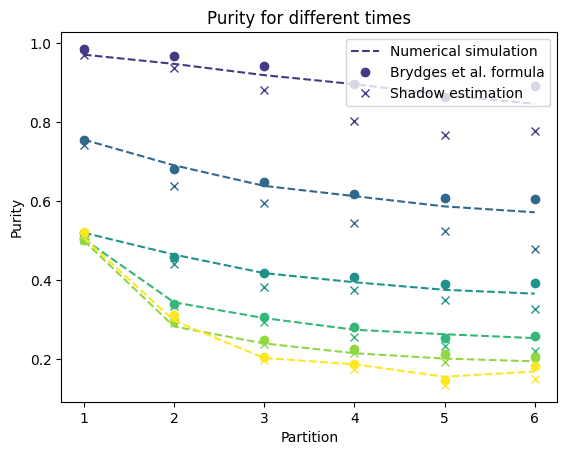

In [25]:
using PyPlot

clf()

cm = get_cmap(:viridis)
for s in 1:ntimes
    plot(1:NA_max,p[s,:,1],"--",color=cm(s/ntimes), label="Numerical simulation")
    plot(1:NA_max,p_direct[s,1:NA_max],"o",color=cm(s/ntimes),label="Brydges et al. formula")
    plot(1:NA_max,p_bshadow[s,:,1],"x",color=cm(s/ntimes), label = "Shadow estimation")
end
#yscale("log")
xlabel("Partition")
ylabel("Purity")
title("Purity for different times")
legend(["Numerical simulation","Brydges et al. formula","Shadow estimation"])
gcf()

We plot the higher order Renyi entropies as a function of Renyi index n for a fixed subystem size and various times.

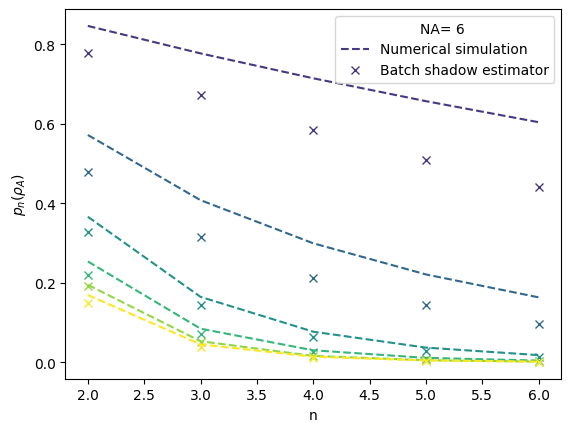

In [26]:
using PyPlot

clf()
cm = get_cmap(:viridis)
NA = 6
for s in 1:1
    plot(2:k_max,p[s,NA,:],"--",color=cm(s/ntimes),label="Numerical simulation")
    plot(2:k_max,p_bshadow[s,NA,:],"x",color=cm(s/ntimes),label="Batch shadow estimator")
end
for s in 2:ntimes
    plot(2:k_max,p[s,NA,:],"--",color=cm(s/ntimes))
    plot(2:k_max,p_bshadow[s,NA,:],"x",color=cm(s/ntimes))
end
xlabel("n")
ylabel(L"p_n(\rho_A)")
legend(title = "NA= $NA ")

gcf()